In [2]:
import pickle

In [3]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as kr
from keras.models import Sequential
from tensorflow.keras import layers, activations, initializers, Input
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.python.framework import tensor_shape
import matplotlib.pyplot as plt
import keras
from tensorflow import data as tf_data
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
datasetTreino = keras.utils.image_dataset_from_directory(
    "C:\Projeto MS904\Sign Language for Alphabets TRAIN",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="grayscale",
    batch_size=None,
    image_size=(100, 100),
    shuffle=True,
    seed=4147,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 34460 files belonging to 27 classes.


In [5]:
datasetTeste = keras.utils.image_dataset_from_directory(
    "C:\Projeto MS904\Sign Language for Alphabets TEST",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="grayscale",
    batch_size=None,
    image_size=(100, 100),
    shuffle=True,
    seed=4147,
    validation_split=None,   
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 6098 files belonging to 27 classes.


Processa dados para np.array

In [6]:
listaDatasetTreino = list(datasetTreino)
listaDatasetTeste = list(datasetTeste)

In [7]:
###### treino

y_treino = np.array([listaDatasetTreino[0][1].numpy()])
for i in range(1,len(datasetTreino)):
  y_treino = np.append(y_treino, np.array([listaDatasetTreino[i][1].numpy()]), axis=0)

x_treino = np.array([listaDatasetTreino[0][0].numpy()])
for i in range(1,len(datasetTreino)):
  x_treino = np.append(x_treino, np.array([listaDatasetTreino[i][0].numpy()]), axis=0)

###### teste

y_teste = np.array([listaDatasetTeste[0][1].numpy()])
for i in range(1,len(datasetTeste)):
  y_teste = np.append(y_teste, np.array([listaDatasetTeste[i][1].numpy()]), axis=0)

x_teste = np.array([listaDatasetTeste[0][0].numpy()])
for i in range(1,len(datasetTeste)):
  x_teste = np.append(x_teste, np.array([listaDatasetTeste[i][0].numpy()]), axis=0)

In [8]:
data_augmentation_layers = [
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.15)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Cria modelo

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(64, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual

    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(27, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# 337ms/step - accuracy: 0.9473 - loss: 0.1661 - val_accuracy: 0.9438 - val_loss: 0.2221

myModel = make_model(input_shape=(100, 100, 1), num_classes=27)
keras.utils.plot_model(myModel, show_shapes=True)
myModel.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 100, 100,  │          0 │ input_layer[0][0] │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_1   │ (None, 100, 100,  │          0 │ random_rotation_… │
│ (RandomContrast)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 100, 100,  │          0 │ random_contrast_… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 50, 50,    │        320 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 50,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     18,496 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 50, 50,    │          0 │ dropout[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 50,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 25, 25,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 25,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 25, 25,    │    147,712 │ add[0][0]       

 Total params: 214,171 (836.61 KB)

 Trainable params: 213,339 (833.36 KB)

 Non-trainable params: 832 (3.25 KB)

# Treinamento rede Real

In [22]:
epochs = 150

callbacks = [
    keras.callbacks.ModelCheckpoint("RealTreinoModelo.weights.h5",save_weights_only=True),
]
myModel.compile(
    optimizer='adam',
    loss=kr.losses.categorical_crossentropy,
    metrics=['accuracy']
)
historico = myModel.fit(
    x_treino,
    y_treino,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=128,
    validation_split = 0.15
)

Epoch 1/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.6335 - loss: 1.2775 - val_accuracy: 0.0428 - val_loss: 16.6969
Epoch 2/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.6740 - loss: 1.1299 - val_accuracy: 0.2115 - val_loss: 6.6528
Epoch 3/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.6870 - loss: 1.0718 - val_accuracy: 0.0445 - val_loss: 14.2161
Epoch 4/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.7094 - loss: 0.9947 - val_accuracy: 0.1960 - val_loss: 3.9345
Epoch 5/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.7287 - loss: 0.9405 - val_accuracy: 0.0729 - val_loss: 11.0279
Epoch 6/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7435 - loss: 0.8769 - val_accuracy: 0.1822 - val_loss: 7.6470
Epoch 7/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.7545 - loss: 0.8517 - val_accuracy: 0.0873 - val_loss: 8.1850
Epoch 8/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.7551 - loss: 0.8415

Salva histórico e modelo

In [23]:
# Salva o histórico

with open('C:/Projeto MS904/RealTreinoHistoryDict', 'wb') as file_pi:
    pickle.dump(historico.history, file_pi)


In [30]:
# abre de novo

with open('C:/Projeto MS904/RealTreinoHistoryDict', "rb") as file_pi:
    historicoCarregado = pickle.load(file_pi)

In [8]:
# Recarrega modelo

myModel = make_model(input_shape=(100, 100, 1), num_classes=27)
myModel.load_weights("C:/Projeto MS904/RealTreinoModelo.weights.h5") 

In [26]:
# Testa o modelo:

historicoTeste = myModel.evaluate(x_teste,y_teste, return_dict=True)

with open('C:/Projeto MS904/RealTesteHistoryDict', 'wb') as file_pi:
    pickle.dump(historicoTeste, file_pi)

191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9541 - loss: 0.1660


In [27]:
# Abre teste histórico

with open('C:/Projeto MS904/RealTesteHistoryDict', "rb") as file_pi:
    historicoCarregado = pickle.load(file_pi)

print(historicoCarregado)

{'accuracy': 0.9532633423805237, 'loss': 0.17050142586231232}


## PLOT

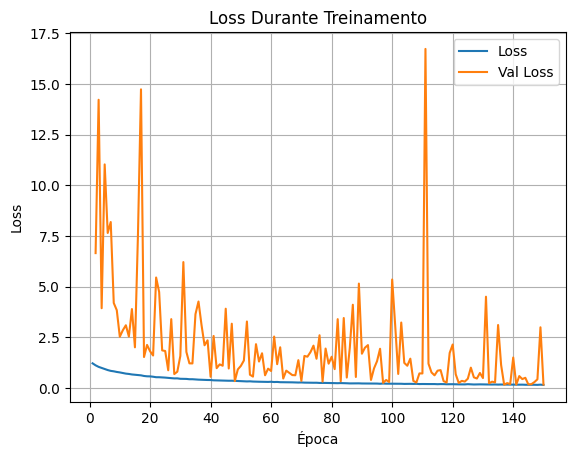

In [28]:
# Plota os dados de treinamento

treino_loss = historico.history['loss']
treino_val_loss = historico.history['val_loss']

epocas = range(1, 150+1) 

plt.plot(epocas, treino_loss)
plt.plot(epocas[1:], treino_val_loss[1:])
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss Durante Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

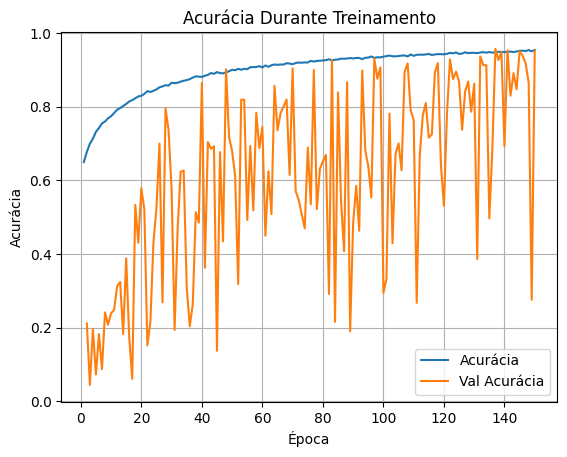

In [31]:
treino_prec = historicoCarregado['accuracy']
treino_val_prec = historicoCarregado['val_accuracy']

epocas = range(1, 150+1) 

plt.plot(epocas, treino_prec)
plt.plot(epocas[1:], treino_val_prec[1:])
plt.legend(['Acurácia', 'Val Acurácia'])
plt.title('Acurácia Durante Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

## Modelo Hipercomplexo

Definindo classes hipercomplexas

In [81]:
class V_Conv2D(kr.layers.Layer):
    def __init__(self,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='VALID',
                 use_bias=True,
                 activation=None,
                 initializer='glorot_normal',
                 data_format=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1) # Complex Numbers
                ):
        super(V_Conv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)
        self.initializer = kr.initializers.get(initializer)
        self.data_format = data_format
        self.algebra = np.float32(algebra)
        self.alg_dim = algebra.shape[2]

    def _get_channel_axis(self):
        if self.data_format == 'channels_first':
            raise ValueError('V_Conv2d is designed only for channels_last. '
                             'The input must be changed to channels last!')
        else:
            return -1

    def _get_input_channel(self, input_shape):
        channel_axis = self._get_channel_axis()
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[channel_axis])

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        if input_channel % self.alg_dim != 0:
            raise ValueError('The number of input channels must be divisible by %d.' % self.alg_dim)

        self.input_dim = input_channel // self.alg_dim
        kernel_shape = self.kernel_size + (self.input_dim, self.filters, self.alg_dim)

        self.kernel = self.add_weight(
            name='kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.alg_dim*self.filters,),
                initializer="zeros",
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None

    def call(self, inputs):
        # Filter multiplied from the right!
        W = sum([tf.experimental.numpy.kron(self.algebra[k,:,:].reshape(1,1,self.alg_dim,self.alg_dim),self.kernel[:,:,:,:,k]) for k in range(self.alg_dim)])
        outputs = tf.nn.conv2d(inputs, W, strides=self.strides, padding=self.padding)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs,self.bias)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

Ajustando modelo

In [79]:
# Ajustando dados de treino e teste

x_treino2 = np.concatenate((np.zeros((x_treino.shape[0],x_treino.shape[1],x_treino.shape[1],1)),x_treino),axis=-1)
x_teste2 = np.concatenate((np.zeros((x_teste.shape[0],x_teste.shape[1],x_teste.shape[1],1)),x_teste),axis=-1)
x_treino2.shape, x_teste2.shape

((34460, 100, 100, 2), (6098, 100, 100, 2))

In [82]:
# Será utilizado a algebra complexa
complex_numbers = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)

In [67]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    
    x = V_Conv2D(32, (3,3), strides=2, padding="SAME",algebra=complex_numbers)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    x = V_Conv2D(48, (3,3), padding="SAME",algebra=complex_numbers)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Activation("relu")(x)
    
    x = V_Conv2D(48, (3,3), padding="SAME",algebra=complex_numbers)(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = V_Conv2D(48, (1,1), strides=2, padding="SAME",algebra=complex_numbers)(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual

    x = V_Conv2D(148, (3,3), padding="SAME",algebra=complex_numbers)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    # We specify activation=None so as to return logits

    outputs = Dense(27, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# 337ms/step - accuracy: 0.9473 - loss: 0.1661 - val_accuracy: 0.9438 - val_loss: 0.2221

myModelHipComplexo = make_model(input_shape=(100, 100, 2), num_classes=27)
keras.utils.plot_model(myModelHipComplexo, show_shapes=True)
myModelHipComplexo.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 100, 100,  │          0 │ input_layer_26[0… │
│ (RandomRotation)    │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_1   │ (None, 100, 100,  │          0 │ random_rotation_… │
│ (RandomContrast)    │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_26        │ (None, 100, 100,  │          0 │ random_contrast_… │
│ (Rescaling)         │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_80        │ (None, 50, 50,    │        640 │ rescaling_26[0][… │
│ (V_Conv2D)          │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ v__conv2d_80[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_81        │ (None, 50, 50,    │     27,744 │ activation_47[0]… │
│ (V_Conv2D)          │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        384 │ v__conv2d_81[0][… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 50, 50,    │          0 │ dropout_35[0][0]  │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_82        │ (None, 50, 50,    │     41,568 │ activation_48[0]… │
│ (V_Conv2D)          │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        384 │ v__conv2d_82[0][… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_83        │ (None, 25, 25,    │      3,168 │ activation_47[0]… │
│ (V_Conv2D)          │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 25, 25,    │          0 │ max_pooling2d_16… │
│                     │ 96)               │            │ v__conv2d_83[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v__conv2d_84        │ (None, 25, 25,    │    128,168 │ add_14[0][0]    

 Total params: 211,515 (826.23 KB)

 Trainable params: 210,411 (821.92 KB)

 Non-trainable params: 1,104 (4.31 KB)

In [73]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("CompTreinoModelo2.weights.h5",save_weights_only=True),
]
myModelHipComplexo.compile(
    optimizer='adam',
    loss=kr.losses.categorical_crossentropy,
    metrics=['accuracy']
)
historico = myModelHipComplexo.fit(
    x_treino2,
    y_treino,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=64,
    validation_split = 0.15
)

458/458 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.9634 - loss: 0.1240 - val_accuracy: 0.9627 - val_loss: 0.1512


In [74]:
# Salva o histórico

with open('C:/Projeto MS904/CompTreinoHistoryDict2', 'wb') as file_pi:
    pickle.dump(historico.history, file_pi)

In [75]:
# Testa o modelo:

historicoTeste = myModelHipComplexo.evaluate(x_teste2,y_teste, return_dict=True)

with open('C:/Projeto MS904/CompTesteHistoryDict2', 'wb') as file_pi:
    pickle.dump(historicoTeste, file_pi) # accuracy: 0.9618 - loss: 0.1456

191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.9618 - loss: 0.1456


## PLOT COMPLEXO

In [5]:
with open('C:/Projeto MS904/CompTreinoHistoryDict', "rb") as file_pi:
    historicoCarregadoComp1 = pickle.load(file_pi)

print(historicoCarregadoComp1)

{'accuracy': [0.3199959099292755, 0.5195794105529785, 0.6091973781585693, 0.6521798372268677, 0.6829401254653931, 0.7051312923431396, 0.725410521030426, 0.7409101724624634, 0.7535761594772339, 0.7698268890380859, 0.7772353291511536, 0.7840974926948547, 0.7953637838363647, 0.7995288372039795, 0.8112389445304871, 0.8153016567230225, 0.8229490518569946, 0.8279334902763367, 0.8361271619796753, 0.8409750461578369, 0.8456863760948181, 0.8452084064483643, 0.8584889769554138, 0.8568843603134155, 0.861049473285675, 0.8638830780982971, 0.8671947121620178, 0.8700966238975525, 0.8769587874412537, 0.8797924518585205, 0.8804410696029663, 0.8817042708396912, 0.8861083388328552, 0.8881226181983948, 0.886688768863678, 0.8937557339668274, 0.8926973938941956, 0.8942337036132812, 0.9005154967308044, 0.8972380757331848, 0.8984329700469971, 0.9028028845787048, 0.9060462117195129, 0.9020518064498901, 0.9066265821456909, 0.9071387052536011, 0.9125328660011292, 0.9111672639846802, 0.9124645590782166, 0.9147861

In [6]:
with open('C:/Projeto MS904/CompTreinoHistoryDict2', "rb") as file_pi:
    historicoCarregadoComp2 = pickle.load(file_pi)

print(historicoCarregadoComp2)

{'accuracy': [0.9617971181869507], 'loss': [0.12621597945690155], 'val_accuracy': [0.9626620411872864], 'val_loss': [0.15121044218540192]}


In [9]:
aux = historicoCarregadoComp1['loss'] + historicoCarregadoComp2['loss']
len(list(range(1,150+1)))

150

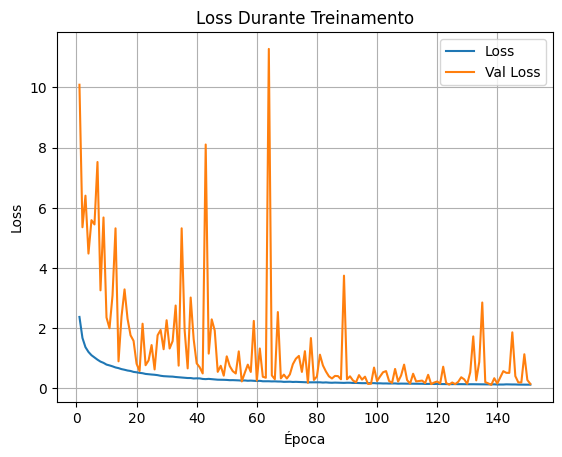

In [11]:
# Plota os dados de treinamento

treino_loss_comp = historicoCarregadoComp1['loss'] + historicoCarregadoComp2['loss']
treino_val_loss_comp = historicoCarregadoComp1['val_loss'] + historicoCarregadoComp2['val_loss']

epocas_comp = range(1, 150+2) 

plt.plot(epocas_comp, treino_loss_comp)
plt.plot(epocas_comp, treino_val_loss_comp)
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss Durante Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

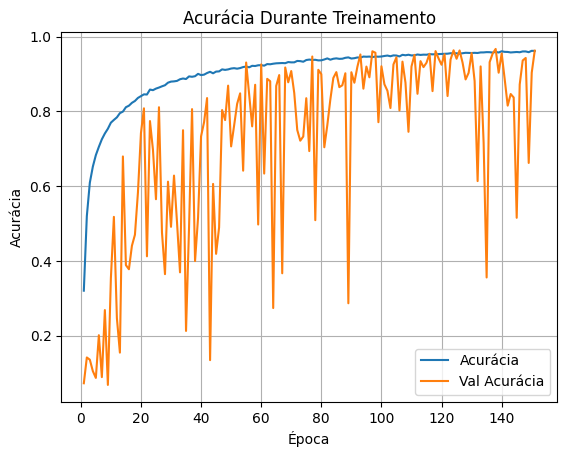

In [12]:
treino_prec_comp = historicoCarregadoComp1['accuracy'] + historicoCarregadoComp2['accuracy']
treino_val_prec_comp = historicoCarregadoComp1['val_accuracy'] + historicoCarregadoComp2['val_accuracy']

epocas_comp = range(1, 150+2) 

plt.plot(epocas_comp, treino_prec_comp)
plt.plot(epocas_comp, treino_val_prec_comp)
plt.legend(['Acurácia', 'Val Acurácia'])
plt.title('Acurácia Durante Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()